In [15]:
import os
import re
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from textwrap import fill
from dotenv import load_dotenv
from openai import OpenAI

import shap
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from IPython.display import display, Markdown

In [16]:
load_dotenv()

client = OpenAI()
print("OPENAI_API_KEY loaded:", os.getenv("OPENAI_API_KEY") is not None)

OPENAI_API_KEY loaded: True


In [3]:
EMBED_MODEL_NAME = "sentence-transformers/all-mpnet-base-v2"
embed_model = SentenceTransformer(EMBED_MODEL_NAME)

Paths and Knowledge Base Loading

In [17]:
BASE_DIR = Path.cwd()              
  
KB_PATH = BASE_DIR / "knowledge_base" / "base_knowledge.md"
EMBED_STORE_PATH = BASE_DIR / "kb_embeddings.joblib"

# Loading knowledge base
kb_text = KB_PATH.read_text(encoding="utf-8")

DEBUG = False
if DEBUG:
    print("KB_PATH:", KB_PATH.resolve())
    print("EMBED_STORE_PATH:", EMBED_STORE_PATH.resolve())
    print(kb_text[:800])

Markdown Chubking

In [18]:
def split_markdown_into_chunks(text, max_chars=700):
    sections = []
    current_title = "Introduction"
    current_buffer = []

    for line in text.splitlines():
        if line.startswith("## "):
            if current_buffer:
                sections.append((current_title, "\n".join(current_buffer).strip()))
                current_buffer = []
            current_title = line.replace("## ", "").strip()
        else:
            current_buffer.append(line)

    if current_buffer:
        sections.append((current_title, "\n".join(current_buffer).strip()))

    chunks = []
    chunk_id = 0

    for title, body in sections:
        body = body.strip()
        if not body:
            continue

        paragraphs = [p.strip() for p in body.split("\n\n") if p.strip()]
        buffer = ""

        for para in paragraphs:
            if len(buffer) + len(para) + 2 <= max_chars:
                buffer = buffer + ("\n\n" + para if buffer else para)
            else:
                chunks.append({"id": chunk_id, "title": title, "text": buffer.strip()})
                chunk_id += 1
                buffer = para

        if buffer:
            chunks.append({"id": chunk_id, "title": title, "text": buffer.strip()})
            chunk_id += 1

    return chunks

Building and Loading Embeddings

In [19]:
if EMBED_STORE_PATH.exists():
    kb_store = joblib.load(EMBED_STORE_PATH)
    print("Loaded kb_store ✅", "chunks:", len(kb_store["chunks"]))
else:
    kb_chunks = split_markdown_into_chunks(kb_text, max_chars=700)
    texts = [c["text"] for c in kb_chunks]

    embeddings = embed_model.encode(
        texts,
        convert_to_numpy=True,
        normalize_embeddings=True
    )

    kb_store = {
        "chunks": kb_chunks,
        "embeddings": embeddings,
        "model_name": EMBED_MODEL_NAME
    }

    joblib.dump(kb_store, EMBED_STORE_PATH)
    print("Built + saved kb_store ✅", "chunks:", len(kb_store["chunks"]))

Loaded kb_store ✅ chunks: 12


RAG Retrieval

In [20]:
def retrieve_similar_chunks(query, kb_store, embed_model, top_k=5, min_score=0.25):
    #To avoid errors in the confusion matrix
    if not kb_store or "chunks" not in kb_store or "embeddings" not in kb_store:
        return []

    chunks = kb_store["chunks"]
    emb_matrix = np.asarray(kb_store["embeddings"])

    if emb_matrix.ndim != 2 or len(chunks) == 0:
        return []

    if len(chunks) != emb_matrix.shape[0]:
        return []

    query_emb = embed_model.encode([query], convert_to_numpy=True, normalize_embeddings=True)
    sims = cosine_similarity(query_emb, emb_matrix)[0]

    if not np.isfinite(sims).all():
        sims = np.nan_to_num(sims, nan=-1.0, posinf=-1.0, neginf=-1.0)

    ranked_idx = sims.argsort()[::-1]

    results = []
    seen_titles = set()

    for idx in ranked_idx:
        score = float(sims[idx])
        if score < min_score:
            break

        chunk = chunks[idx]
        title = chunk.get("title", "")

        if title in seen_titles:
            continue

        results.append({
            "id": chunk.get("id", idx),
            "title": title,
            "text": chunk.get("text", ""),
            "score": score
        })

        seen_titles.add(title)

        if len(results) >= top_k:
            break

    return results

Building the RAG Context

In [21]:
def build_explanation_query(predicted_class, driver_text):
    return (
        f"Explain why this investor is classified as {predicted_class}. "
        f"Important factors: {driver_text}. "
        "Use simple language."
    )

def get_rag_context(predicted_class, driver_text, kb_store, embed_model, top_k=5, min_score=0.25):
    query = build_explanation_query(predicted_class, driver_text)
    retrieved = retrieve_similar_chunks(query, kb_store, embed_model, top_k=top_k, min_score=min_score)

    context = "\n\n".join(
        f"### {r['title']}\n{r['text']}"
        for r in retrieved
    )

    return query, context, retrieved

LLM explanation generation

In [ ]:
def generate_rag_explanation(
    predicted_class: str,
    driver_text_user: str,
    driver_text_tech: str,
    kb_store: dict,
    embed_model,
    top_k: int = 5,
    min_score: float = 0.25,
    llm_model: str = "gpt-4.1-mini",
):
    # Using technical drivers for retrieval strength
    rag_query, context, retrieved = get_rag_context(
        predicted_class,
        driver_text_tech,
        kb_store,
        embed_model,
        top_k=top_k,
        min_score=min_score
    )

    prompt = f"""
Explaining a robo-advisor risk classification to the retail investor.

Rules:
- Use clear, simple language.
- Use ONLY the information in the CONTEXT. Do not invent facts.
- Do NOT give investment advice or recommendations.
- Do NOT mention specific assets or allocations.
- End with this exact sentence:
"This explanation is for educational purposes only and is not financial advice."

PREDICTED CLASS:
{predicted_class}

KEY FACTORS (simplified):
{driver_text_user}

CONTEXT:
{context}

Write 2–3 short paragraphs.
""".strip()

    resp = client.responses.create(model=llm_model, input=prompt)

    # safest extraction
    explanation = getattr(resp, "output_text", None)
    if not explanation:
        explanation = resp.output[0].content[0].text

    return explanation, rag_query, retrieved

In [23]:
MODEL_PATH = BASE_DIR.parent / "rf_risk_classifier.joblib"
DATA_PATH = BASE_DIR.parent / "investor_profiles_cleaned.csv"

model_pipe = joblib.load(MODEL_PATH)
df = pd.read_csv(DATA_PATH)

print("Model loaded ✅")
print("Data shape:", df.shape)
df.head()

Model loaded ✅
Data shape: (4756, 9)


,age,income_band,financial_knowledge,investment_experience,risk_preference,loss_aversion,investment_horizon_years,primary_goal,risk_profile
0,39,Medium,Low,Basic,Avoid risk,Very uncomfortable with losses,10,Aggressive growth,Conservative
1,33,Low,Medium,No experience,Avoid risk,Can accept small losses,5,Capital preservation,Conservative
2,41,Medium,Medium,No experience,Comfortable with some risk,Very uncomfortable with losses,5,Aggressive growth,Conservative
3,50,Medium,Medium,No experience,Comfortable with high risk,Can accept small losses,5,Capital preservation,Conservative
4,32,High,Medium,Advanced,Comfortable with some risk,Can accept small losses,15,Balanced growth,Moderate


              precision    recall  f1-score   support

  Aggressive       1.00      0.72      0.83        88
Conservative       0.97      0.89      0.93       278
    Moderate       0.91      0.99      0.95       586

    accuracy                           0.93       952
   macro avg       0.96      0.87      0.90       952
weighted avg       0.94      0.93      0.93       952



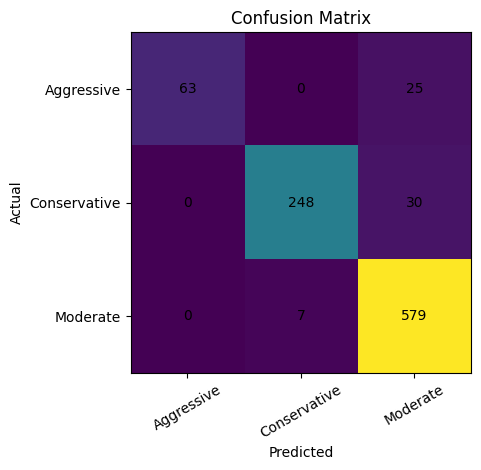

In [24]:
X = df.drop(columns=["risk_profile"], errors="ignore")
y = df["risk_profile"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

y_pred = model_pipe.predict(X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=model_pipe.classes_)

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(range(len(model_pipe.classes_)), model_pipe.classes_, rotation=30)
plt.yticks(range(len(model_pipe.classes_)), model_pipe.classes_)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

SHAP

In [25]:
def prettify_feature_name(name: str) -> str:
    name = re.sub(r"^(ordinal_|nominal_|numeric_)", "", name)
    return name.replace("_", " ")

In [26]:
def build_driver_text_user(top_features, pred_class, k=5):
    lines = []
    for feat, val in top_features[:k]:
        clean = prettify_feature_name(feat)
        direction = "supports" if val > 0 else "reduces"
        lines.append(f"- {clean} ({direction} {pred_class})")
    return "\n".join(lines)

In [27]:
def build_driver_text_tech(top_features, pred_class, k=5):
    lines = []
    for feat, val in top_features[:k]:
        clean = prettify_feature_name(feat)
        direction = "pushes toward" if val > 0 else "pushes away from"
        lines.append(f"- {clean}: {val:+.4f} ({direction} {pred_class})")
    return "\n".join(lines)

Full per-user pipeline

In [28]:
def run_full_explanation_for_row(row_idx, top_k=5, min_score=0.25):
    # 1) Input row
    X_all = df.drop(columns=["risk_profile"], errors="ignore")
    X_one = X_all.iloc[[row_idx]]

    # 2) Prediction
    pred_class = model_pipe.predict(X_one)[0]
    proba = model_pipe.predict_proba(X_one)[0]
    classes = model_pipe.classes_
    probs_dict = dict(zip(classes, np.round(proba, 3)))

    # 3) SHAP
    preprocessor = model_pipe.named_steps["preprocessor"]
    clf = model_pipe.named_steps["model"]

    X_trans = preprocessor.transform(X_one)
    feature_names = preprocessor.get_feature_names_out()

    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_trans)

    class_idx = list(clf.classes_).index(pred_class)

    if isinstance(shap_values, list):
        sv = shap_values[class_idx][0]
    else:
        sv = shap_values[0, :, class_idx]

    abs_idx = np.argsort(np.abs(sv))[::-1][:6]
    top_features = [(feature_names[i], float(sv[i])) for i in abs_idx]

    # 4) Driver texts
    driver_text_user = build_driver_text_user(top_features, pred_class, k=5)
    driver_text_tech = build_driver_text_tech(top_features, pred_class, k=5)

    # 5) RAG + LLM
    explanation, rag_query, rag_chunks = generate_rag_explanation(
        predicted_class=pred_class,
        driver_text_user=driver_text_user,
        driver_text_tech=driver_text_tech,
        kb_store=kb_store,
        embed_model=embed_model,
        top_k=top_k,
        min_score=min_score
    )

    return {
        "row_idx": row_idx,
        "pred_class": pred_class,
        "probs": probs_dict,
        "top_features": top_features,
        "driver_text_user": driver_text_user,
        "driver_text_tech": driver_text_tech,
        "rag_query": rag_query,
        "rag_chunks": rag_chunks,
        "explanation": explanation,
    }

Graphs for Probabilities and SHAP

In [31]:
def plot_probabilities(probs_dict, title="Class Probabilities"):
    labels = list(probs_dict.keys())
    vals = [float(probs_dict[k]) for k in labels]

    plt.figure()
    plt.bar(labels, vals)
    plt.ylim(0, 1)
    plt.title(title)
    plt.ylabel("Probability")
    plt.tight_layout()
    plt.show()

def shap_table(top_features):
    df_shap = pd.DataFrame(
        [(prettify_feature_name(f), v) for f, v in top_features],
        columns=["Feature", "SHAP Contribution"]
    )
    return df_shap

def plot_shap_bar(shap_df, title="Top SHAP Drivers"):
    plt.figure()
    plt.barh(shap_df["Feature"], shap_df["SHAP Contribution"])
    plt.axvline(0)
    plt.title(title)
    plt.xlabel("SHAP contribution")
    plt.tight_layout()
    plt.show()

In [32]:
X_all = df.drop(columns=["risk_profile"], errors="ignore")
preds = model_pipe.predict(X_all)

rng = np.random.default_rng(42)

def pick_random_idx(target_class):
    candidates = np.where(preds == target_class)[0]
    return int(rng.choice(candidates))

moderate_idx = pick_random_idx("Moderate")
conservative_idx = pick_random_idx("Conservative")
aggressive_idx = pick_random_idx("Aggressive")

moderate_result = run_full_explanation_for_row(moderate_idx, top_k=5)
conservative_result = run_full_explanation_for_row(conservative_idx, top_k=5)
aggressive_result = run_full_explanation_for_row(aggressive_idx, top_k=5)

print("Moderate idx:", moderate_idx)
print("Conservative idx:", conservative_idx)
print("Aggressive idx:", aggressive_idx)

Moderate idx: 438
Conservative idx: 3600
Aggressive idx: 3068


In [37]:
conservative_result

{'row_idx': 3600,
 'pred_class': 'Conservative',
 'probs': {'Aggressive': np.float64(0.0),
  'Conservative': np.float64(0.58),
  'Moderate': np.float64(0.42)},
 'top_features': [('nominal__primary_goal_Aggressive growth',
   -0.16953435755778143),
  ('ordinal__financial_knowledge', 0.16638338813952613),
  ('ordinal__investment_experience', 0.15732954894409915),
  ('numeric__investment_horizon_years', -0.12533439977740335),
  ('nominal__income_band_Low', 0.10755425823836441),
  ('numeric__age', 0.10105039201341211)],
 'driver_text_user': '-  primary goal Aggressive growth (reduces Conservative)\n-  financial knowledge (supports Conservative)\n-  investment experience (supports Conservative)\n-  investment horizon years (reduces Conservative)\n-  income band Low (supports Conservative)',
 'driver_text_tech': '-  primary goal Aggressive growth: -0.1695 (pushes away from Conservative)\n-  financial knowledge: +0.1664 (pushes toward Conservative)\n-  investment experience: +0.1573 (pushes t

In [42]:
pd.DataFrame(
    conservative_result["probs"].items(),
    columns=["Risk Profile", "Predicted Probability"]
)

,Risk Profile,Predicted Probability
0,Aggressive,0.00
1,Conservative,0.58
2,Moderate,0.42


In [34]:
display(Markdown("## Conservative explanation"))
display(Markdown(conservative_result["explanation"]))

## Conservative explanation

Your classification as a Conservative investor means you prefer stability and lower risk when it comes to investing. This usually happens when someone values protecting their capital and is comfortable with smaller, steadier returns rather than larger but more volatile gains. Factors like having lower income and solid financial knowledge and investment experience support this cautious approach.

The result also reflects that your primary goal is not aggressive growth, and your investment time frame may be shorter. People with shorter horizons tend to avoid higher risk because they have less time to recover from market downturns. Overall, the focus is on keeping your investments stable and avoiding big fluctuations.

This explanation is for educational purposes only and is not financial advice.

In [38]:
moderate_result

{'row_idx': 438,
 'pred_class': 'Moderate',
 'probs': {'Aggressive': np.float64(0.0),
  'Conservative': np.float64(0.125),
  'Moderate': np.float64(0.875)},
 'top_features': [('ordinal__risk_preference', 0.18969890726471983),
  ('numeric__investment_horizon_years', 0.13735897818294113),
  ('ordinal__investment_experience', 0.12786202715681508),
  ('numeric__age', 0.06753315471666407),
  ('ordinal__financial_knowledge', 0.06343221206851492),
  ('nominal__primary_goal_Capital preservation', -0.03145598945712188)],
 'driver_text_user': '-  risk preference (supports Moderate)\n-  investment horizon years (supports Moderate)\n-  investment experience (supports Moderate)\n-  age (supports Moderate)\n-  financial knowledge (supports Moderate)',
 'driver_text_tech': '-  risk preference: +0.1897 (pushes toward Moderate)\n-  investment horizon years: +0.1374 (pushes toward Moderate)\n-  investment experience: +0.1279 (pushes toward Moderate)\n-  age: +0.0675 (pushes toward Moderate)\n-  financia

In [41]:
pd.DataFrame(
    moderate_result["probs"].items(),
    columns=["Risk Profile", "Predicted Probability"]
)

,Risk Profile,Predicted Probability
0,Aggressive,0.000
1,Conservative,0.125
2,Moderate,0.875


In [33]:
display(Markdown("## Moderate explanation"))
display(Markdown(moderate_result["explanation"]))

## Moderate explanation

Your risk classification as moderate means you are comfortable with some level of investment risk while still wanting to manage how much your portfolio might fluctuate. This balance is reflected in your risk preference, experience, financial knowledge, age, and investment horizon. You generally accept short-term ups and downs in exchange for the possibility of balanced growth over time.

A moderate risk profile fits investors who want to grow their investments but prefer to limit exposure to extreme market swings. Your investment horizon, or how long you plan to stay invested, helps support this since having several years allows for recovery from short-term losses. Your financial knowledge and experience also contribute to this classification, showing that you understand the potential risks and rewards involved.

This explanation is for educational purposes only and is not financial advice.

In [39]:
aggressive_result

{'row_idx': 3068,
 'pred_class': 'Aggressive',
 'probs': {'Aggressive': np.float64(0.775),
  'Conservative': np.float64(0.0),
  'Moderate': np.float64(0.225)},
 'top_features': [('ordinal__financial_knowledge', 0.18023948988154456),
  ('ordinal__risk_preference', 0.17640335153500042),
  ('ordinal__investment_experience', -0.17368700949781168),
  ('nominal__income_band_High', 0.14535722628657),
  ('nominal__primary_goal_Aggressive growth', -0.09359670930714831),
  ('numeric__age', 0.06854229938683251)],
 'driver_text_user': '-  financial knowledge (supports Aggressive)\n-  risk preference (supports Aggressive)\n-  investment experience (reduces Aggressive)\n-  income band High (supports Aggressive)\n-  primary goal Aggressive growth (reduces Aggressive)',
 'driver_text_tech': '-  financial knowledge: +0.1802 (pushes toward Aggressive)\n-  risk preference: +0.1764 (pushes toward Aggressive)\n-  investment experience: -0.1737 (pushes away from Aggressive)\n-  income band High: +0.1454 (pu

In [40]:
pd.DataFrame(
    aggressive_result["probs"].items(),
    columns=["Risk Profile", "Predicted Probability"]
)

,Risk Profile,Predicted Probability
0,Aggressive,0.775
1,Conservative,0.000
2,Moderate,0.225


In [35]:
display(Markdown("## Aggressive explanation"))
display(Markdown(aggressive_result["explanation"]))

## Aggressive explanation

You have been classified as an aggressive investor because your answers show you are comfortable with market ups and downs and have strong financial knowledge. Your preference to take risks and your high income also support this classification. While your investment experience slightly lowers the aggressiveness, your overall profile still leans toward seeking strong long-term growth.

Being classified as aggressive means you are more willing to accept fluctuations in the market in exchange for the potential of higher returns over time. This profile usually fits investors who plan to stay invested for a longer period, allowing them to recover from short-term losses and focus on growth.

This explanation is for educational purposes only and is not financial advice.

In [48]:
import matplotlib.pyplot as plt

def plot_shap_bar(shap_df, title="Top SHAP Drivers"):
    # Color positive contributions blue, negative contributions red
    colors = shap_df["SHAP Contribution"].apply(
        lambda x: "#1f77b4" if x > 0 else "#d62728"
    )

    plt.figure(figsize=(7, 4))
    plt.barh(
        shap_df["Feature"],
        shap_df["SHAP Contribution"],
        color=colors
    )

    plt.axvline(0, linewidth=0.8)
    plt.title(title)
    plt.xlabel("SHAP Contribution")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

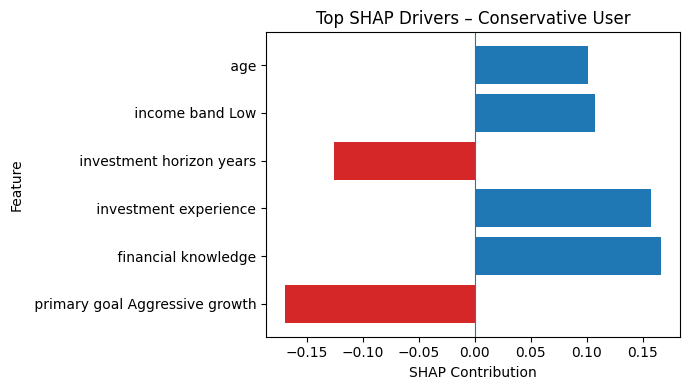

In [49]:
plot_shap_bar(
    shap_df_cons,
    title="Top SHAP Drivers – Conservative User"
)

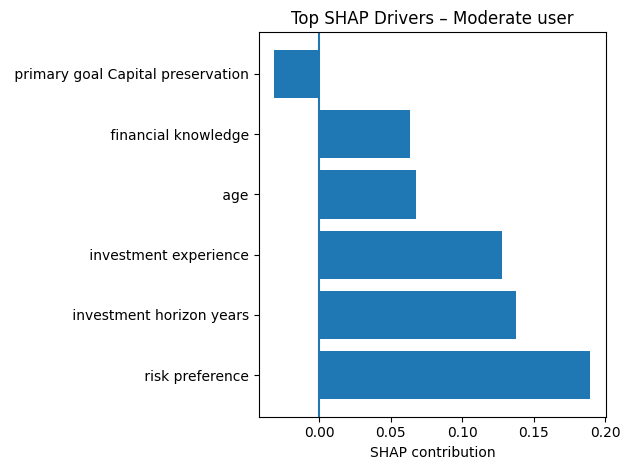

,Feature,SHAP Contribution
0,risk preference,0.189699
1,investment horizon years,0.137359
2,investment experience,0.127862
3,age,0.067533
4,financial knowledge,0.063432
5,primary goal Capital preservation,-0.031456


In [43]:
# SHAP charts
shap_df_mod = shap_table(moderate_result["top_features"])
plot_shap_bar(shap_df_mod, "Top SHAP Drivers – Moderate user")
display(shap_df_mod)

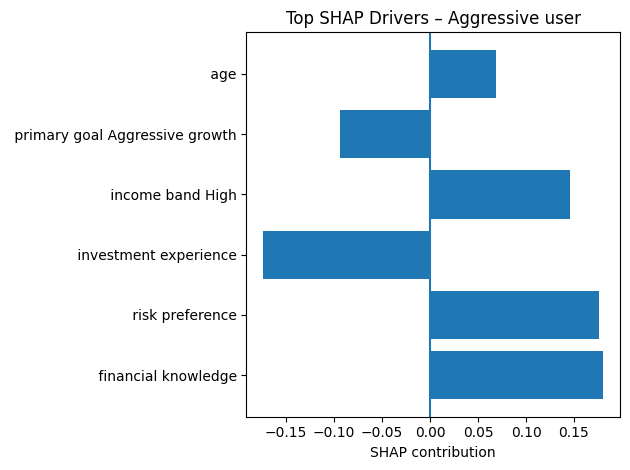

,Feature,SHAP Contribution
0,financial knowledge,0.180239
1,risk preference,0.176403
2,investment experience,-0.173687
3,income band High,0.145357
4,primary goal Aggressive growth,-0.093597
5,age,0.068542


In [45]:
shap_df_aggr = shap_table(aggressive_result["top_features"])
plot_shap_bar(shap_df_aggr, "Top SHAP Drivers – Aggressive user")
display(shap_df_aggr)